In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import pyslsa
import neuraltda.simpComp as sc
import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import os
import glob
%matplotlib inline

In [22]:
def generate_params(n_samp, n_feat, n_clusters, std):
    p = make_blobs(n_samp, n_features=n_feat, centers = n_clusters, cluster_std=std, center_box=(0.01, 0.05))
    return np.absolute(p[0])

def generate_spiketrains(params, ncells, nwin, nsamples2):
    sptrains = []
    for param in tqdm.tqdm(params):
        n_features = len(param)
        probs = []
        for feat in range(n_features):
            probs.append(param[feat]*np.ones((ncells, 1)))
        #a = param[0]
        #b = param[1]
        #probs = np.ones((2*ncells, 1))
        #probs1 = (a*np.ones((ncells, 1)))
        #probs2 = (b*np.ones((ncells, 1)))
        #probs = np.vstack((probs1, probs2))
        probs = np.vstack(probs)
        # Generate new spike trains
        samples = np.random.rand(n_features*ncells, nwin, nsamples2)
        probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
        probmat = np.tile(probmat, (1, 1, nsamples2))
        binMatsamples = np.greater(probmat, samples).astype(int)
        
        sptrains.append(binMatsamples)
    return sptrains

def compute_pairwise_spiketrain_distances(sptrains, dim, beta):
    (ncells, nwin, nsamps) = np.shape(sptrains[0])
    distmat = np.zeros((len(sptrains), len(sptrains), nsamps))
    print("Computing distances")
    for I, sptrainA in tqdm.tqdm(enumerate(sptrains)):
        for J, sptrainB in enumerate(sptrains):
            for samp in range(nsamps):
                # compute SCGs
                maxsimpsA = sc.binarytomaxsimplex(sptrainA[:, :, samp], rDup=True)
                maxsimpsB = sc.binarytomaxsimplex(sptrainB[:, :, samp], rDup=True)
                # Compute SCG for test spike trains
                #Emodel = Emodels[ind]
                EA = pyslsa.build_SCG(maxsimpsA)
                EB = pyslsa.build_SCG(maxsimpsB)
                dist = pyslsa.JS(EA, EB, dim, beta)
                distmat[I, J, samp] = dist
    return distmat

def compute_pairwise_spiketrain_distances_KL(sptrains, dim, beta):
    distmat = np.zeros((len(sptrains), len(sptrains)))
    print("Computing distances")
    for I, sptrainA in tqdm.tqdm(enumerate(sptrains)):
        for J, sptrainB in enumerate(sptrains):
            
            # compute SCGs
            maxsimpsA = sc.binarytomaxsimplex(sptrainA[:, :, 0], rDup=True)
            maxsimpsB = sc.binarytomaxsimplex(sptrainB[:, :, 0], rDup=True)
            # Compute SCG for test spike trains
            #Emodel = Emodels[ind]
            EA = pyslsa.build_SCG(maxsimpsA)
            EB = pyslsa.build_SCG(maxsimpsB)
            dist = (pyslsa.KL(EA, EB, dim, beta) + pyslsa.KL(EB, EA, dim, beta))/2
            distmat[I, J] = dist
    return distmat

def compute_pairwise_spiketrain_distances_JS_dimsum(sptrains, dims, beta):
    # computes the pairwise distances by summing the JS div in each dimension in dims
    (ncells, nwin, nsamps) = np.shape(sptrains[0])
    distmat = np.zeros((len(sptrains), len(sptrains), nsamps))
    print("Computing distances")
    for I, sptrainA in tqdm.tqdm(enumerate(sptrains)):
        for J, sptrainB in enumerate(sptrains):
            for samp in range(nsamps):
                # compute SCGs
                maxsimpsA = sc.binarytomaxsimplex(sptrainA[:, :, samp], rDup=True)
                maxsimpsB = sc.binarytomaxsimplex(sptrainB[:, :, samp], rDup=True)
                # Compute SCG for test spike trains
                #Emodel = Emodels[ind]
                EA = pyslsa.build_SCG(maxsimpsA)
                EB = pyslsa.build_SCG(maxsimpsB)
                dist = 0.0
                for dim in dims:
                    dist += pyslsa.JS(EA, EB, dim, beta) 
                distmat[I, J, samp] = dist
    return distmat

In [32]:
params = generate_params(50, 1, 2, 0.0005)
sptrains = generate_spiketrains(params, 10, 1000, 5)

100%|██████████| 50/50 [00:00<00:00, 848.83it/s]


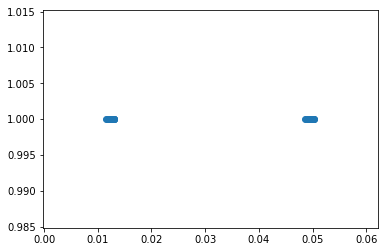

In [33]:
plt.scatter(params[:, 0], np.ones(len(params[:, 0])))

In [107]:
distmat = compute_pairwise_spiketrain_distances(sptrains, 1, -5)

0it [00:00, ?it/s]

Computing distances


50it [01:51,  2.26s/it]


In [72]:
distmat = compute_pairwise_spiketrain_distances_KL(sptrains, 1, -1)

0it [00:00, ?it/s]

Computing distances


50it [00:49,  1.34s/it]


In [36]:
distmat = compute_pairwise_spiketrain_distances_JS_dimsum(sptrains, [1,2,3], -5.0)

0it [00:00, ?it/s]

Computing distances


50it [00:57,  1.14s/it]


In [12]:
# Do Hierarchical clustering
def pyslsa_HC(full_dist_mat, stims):
    
    # compute reduced density mat
    dist_mat = squareform(full_dist_mat, checks=False)
    # Compute and plot first dendrogram.
    fig = plt.figure(figsize=(8,8))
    # x ywidth height
    ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
    Y = linkage(dist_mat, method='single')
    Z1 = dendrogram(Y, orientation='left',labels=stims) # adding/removing the axes
    ax1.set_xticks([])

    # Compute and plot second dendrogram.
    ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
    Z2 = dendrogram(Y)
    ax2.set_xticks([])
    ax2.set_yticks([])

    #Compute and plot the heatmap
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = squareform(dist_mat, checks=False)
    D = D[idx1,:]
    D = D[:,idx2]
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
    plt.colorbar(im, cax=axcolor)


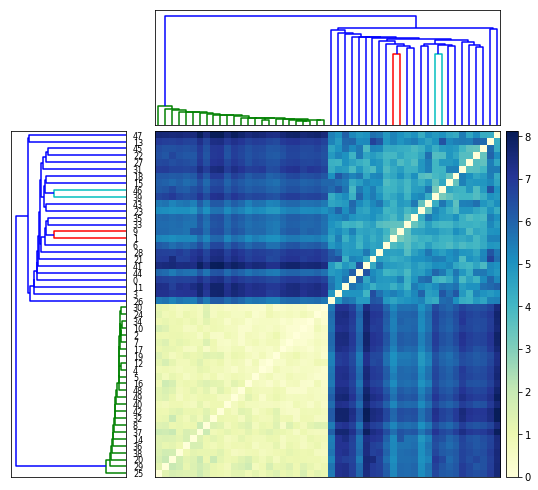

In [38]:
distmat2 = np.mean(distmat, axis=2)
pyslsa_HC(distmat2, range(50))

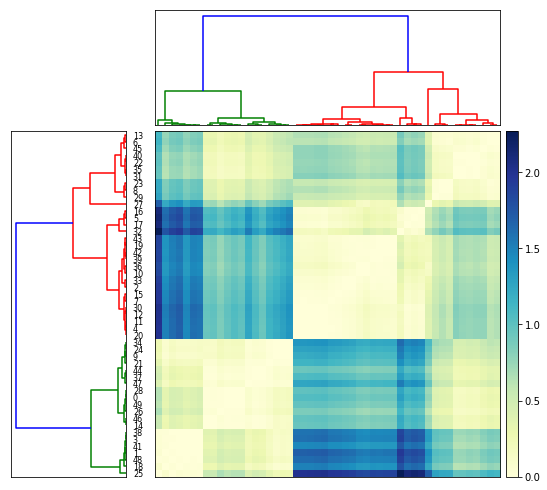

In [73]:
pyslsa_HC(distmat, range(50))

In [37]:
params.shape

(100, 2)